### Loading Data
Dan Constantini, Tom Hayat et Alexandre Attia
This script loads 11 data class from imagenet and sort the files according to their name

eiffel_tower	


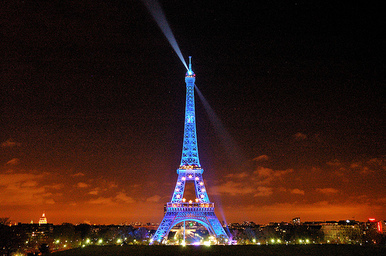

In [8]:
require 'torch'
require 'xlua'
require 'image'

files = {}
compteur=0
--classes={'bridge', 'building', 'city', 'eiffel_tower','elephant', 'landscape', 'lion', 'monkey', 'people', 'tower', 'water'}

for file in paths.files('/Users/alexandreattia/Desktop/ENPC/ComputerScience/Torch/Deep-Learning/dataset/train/eiffel_tower') do
   if file:find('JPEG' .. '$') then
      table.insert(files, paths.concat('/Users/alexandreattia/Desktop/ENPC/ComputerScience/Torch/Deep-Learning/dataset/train/eiffel_tower',file))
   end
end

if #files == 0 then
   error('given directory doesnt contain any files of type: ' .. opt.ext)
end

table.sort(files, function (a,b) return a < b end)

trainData={data,labels}
trainData.labels={}
trainData.data = {}
for i,file in ipairs(files) do
   -- load each image
   table.insert(trainData.data, image.load(file))
   trainData.labels[i]='eiffel_tower'
end


for i = 1,math.min(#files,1) do
   itorch.image(trainData.data[i])
   print(trainData.labels[i])
end
